# Replicating Results


### What is this?
This notebook provides step-by-step instructions for replicating the results for multi-adjustment

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

import os
import yaml
import sqlalchemy
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = None

from IPython.display import display 
from itertools import permutations, combinations
from jinja2 import Template
import dateparser


from ohio.ext.numpy import pg_copy_to_table

Specify The Database, demo_col of interest, demo_values of interest and the procedure you wish to use for adjustment

In [2]:
database_directory = "education_crowdfunding_replication"

In [3]:
notebook_config = None
with open(database_directory+"/config.yaml") as f:
    notebook_config = yaml.full_load(f)

In [4]:
database = notebook_config["database"]

In [5]:
working_schema = notebook_config['working_schema']

In [6]:
results_schema = notebook_config['results_schema']

In [7]:
demo_col = notebook_config['demo_col']

In [8]:
demo_values = notebook_config['demo_values']

In [9]:
tsteps = ["2011-05-01", "2011-09-01"]

## Getting Set Up

You will need a database with the following schemas:
- **public**: The raw data from donors choose as well as some tables with calculated features and intermediate modeling tables
- **model_metadata**: Information about the models we ran, such as model types and hyperparameters (models were run with `triage`, which generates this schema. In `triage` a "model group" specifies a type of model and associated hyperparameter values, while a "model" is an instantiation of a given model group on a specific temporal validation split). Note that this schema contains information on other model runs with this dataset, in addition to the run used for the current study of fairness-accuracy trade-offs.
- **test_results**: Validation set statistics and predictions for the models. Here, `test_results.predictions` contains project-level predicted scores from each model in the grid, while `test_results.evaluations` contains aggregated summary statistics for each model.
- **train_results**: Training set statistics for the models, including feature importances.
- **features**: Intermediate tables containing calculated features from the `triage` run.
- **bias_working**: Intermediate tables from the bias analysis, as well as the mapping table between projects and school poverty levels, `bias_working.entity_demos`.
- **bias_results_submitted**: Results of the fairness-accuracy trade-offs from the study as submitted (see below to use these to replicate the figures from the study).
- **bias_results**: Empty bias analysis results tables that will be populated by re-running the fairness adjustments (see below for instructions).


Finally, to connect to the database, you'll need a yaml file named `db_profile.yaml` in the same directory as this notebook with your connection info:
```yaml
host: {POSTGRES_HOST}
user: {POSTGRES_USER}
db: education_crowdfunding
pass: {POSTGRES_PASSWORD}
port: {POSTGRES_PORT}
```


In [10]:
with open('../config/db_default_profile.yaml') as fd:
    config = yaml.full_load(fd)
    dburl = sqlalchemy.engine.url.URL(
        "postgresql",
        host=config["host"],
        username=config["user"],
        database=database,
        password=config["pass"],
        port=config["port"],
    )
    engine = sqlalchemy.create_engine(dburl, poolclass=sqlalchemy.pool.QueuePool)

/tmp/ipykernel_20193/2557988758.py:3: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  dburl = sqlalchemy.engine.url.URL(


In [11]:
def get_entity_dataframes():
    df = pd.read_sql(f"SELECT * FROM {working_schema}.entity_distribution order by 1;", engine)
    delta_df = pd.read_sql(f"SELECT * FROM {working_schema}.entity_delta_distribution order by 1", engine)
    return df, delta_df

In [12]:
df, delta_df = get_entity_dataframes()

In [13]:
df.head()

,train_end_time,model_rank,rn_demo,demo_value,recall_demo_rolling,precision_demo_rolling,score
0,2011-03-01,5,1,highest,0.000000,0.000000,0.66157
1,2011-03-01,2998,1954,not_highest,0.189956,0.667861,0.47370
2,2011-03-01,2997,1953,not_highest,0.189956,0.668203,0.47373
3,2011-03-01,2996,1952,not_highest,0.189811,0.668033,0.47373
4,2011-03-01,2995,1951,not_highest,0.189665,0.667863,0.47374


In [14]:
delta_df.head()

,train_end_time,demo_value,base_group_k,base_model_rank,base_recall_demo_rolling,base_precision_demo_rolling,base_score,adj_group_k,adj_model_rank,adj_recall_demo_rolling,adj_precision_demo_rolling,adj_score,multi_adj_group_k,multi_adj_model_rank,multi_adj_recall_demo_rolling,multi_adj_precision_demo_rolling,multi_adj_score
0,2011-03-01,highest,281,11,0.000799,0.007510,0.00045,587,13,0.000457,0.003803,0.00034,587,13,0.000457,0.003803,0.00034
1,2011-03-01,not_highest,719,27,0.001019,0.002522,0.00114,413,10,0.000728,0.004151,0.00121,413,10,0.000728,0.004151,0.00121
2,2011-05-01,highest,339,39,0.000905,0.005087,0.00188,574,25,0.000129,0.008641,0.00082,574,25,0.000129,0.008641,0.00082
3,2011-05-01,not_highest,661,12,0.000663,0.002664,0.00042,426,15,0.000663,0.004541,0.00068,426,15,0.000663,0.004541,0.00068
4,2011-07-01,highest,361,30,0.001015,0.007768,0.00129,587,12,0.000725,0.002915,0.00035,587,12,0.000725,0.002915,0.00035


In [15]:
import matplotlib.dates as mdates

months = mdates.MonthLocator([1, 2,3, 4,5, 6, 7, 8, 9, 10, 11, 12])
months_fmt = mdates.DateFormatter('%b %y')

In [16]:
def plot_dist(metric="score", ylabel="Score", include_timesteps=[]):
    times = [np.datetime64(date) for date in include_timesteps]
    timesteps = df["train_end_time"].unique()
    for timestep in timesteps:
        if len(include_timesteps) != 0 and timestep not in times:
            continue
        for d_value in demo_values:
            true_slice = df[(df["demo_value"].apply(lambda x: x.lower()) == d_value) & ((df["train_end_time"] == timestep))]
            conditions = (delta_df["train_end_time"] == timestep) & (delta_df["demo_value"].apply(lambda x: x.lower()) == d_value)
            base_k = delta_df[conditions]["base_group_k"].mean()
            adj_k = delta_df[conditions]["adj_group_k"].mean()
            multi_adj_k = delta_df[conditions]["multi_adj_group_k"].mean()
            sns.lineplot(data=true_slice, x="rn_demo", y=metric, label=ylabel)
            plt.axvline(x=base_k, label="Unadjusted", color="black")
            plt.axvline(x=adj_k, label="Adjusted", color="green")
            plt.axvline(x=multi_adj_k, label="M. Adjusted", color="red")
            plt.xlabel("Rank within Demography")
            plt.ylabel(ylabel)
            t_string = f"{timestep}"[:10]
            plt.title(f"{ylabel} Distribution for {d_value} on {t_string}")
            plt.legend()
            plt.show()
            plt.clf()

In [17]:
def plot_delta_dist(metric="score", ylabel="Score"):
    for d_value in demo_values:
        true_slice = delta_df[delta_df["demo_value"].apply(lambda x: x.lower()) == d_value]
        for mod in ["base", "adj"]: # can add multiadj if I want
            ax = sns.lineplot(data=true_slice, x="train_end_time", y=f"{mod}_{metric}", label=ylabel)
            ax.set_xlabel('Test Set Date', fontsize=14)
            ax.xaxis.set_major_locator(months)
            ax.xaxis.set_major_formatter(months_fmt)
            plt.ylabel(ylabel)
            plt.title(f"Range of {d_value} {ylabel} around select k using method: {mod}")
            plt.legend()
            plt.show()
            plt.clf()
            

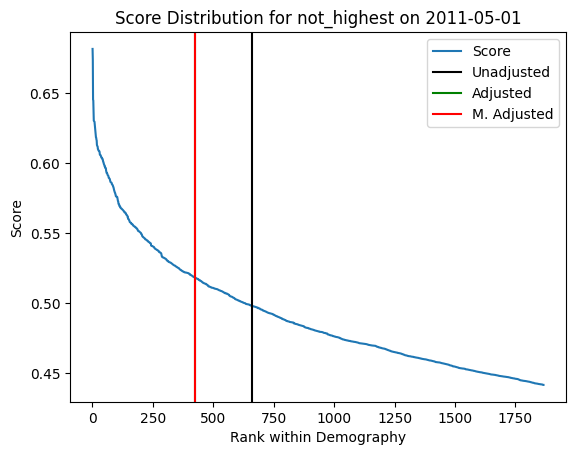

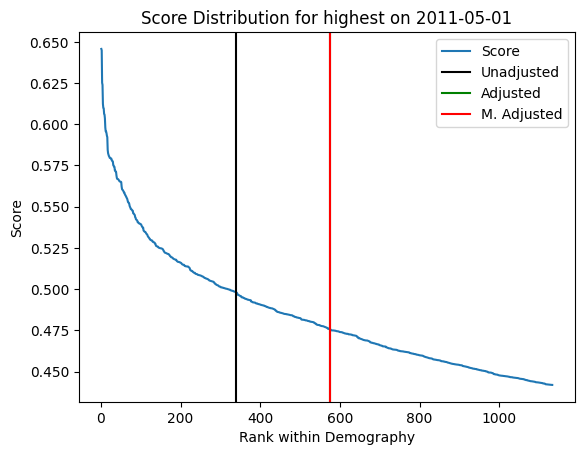

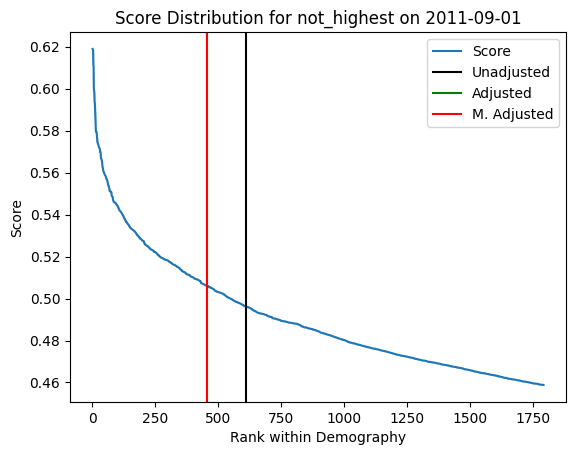

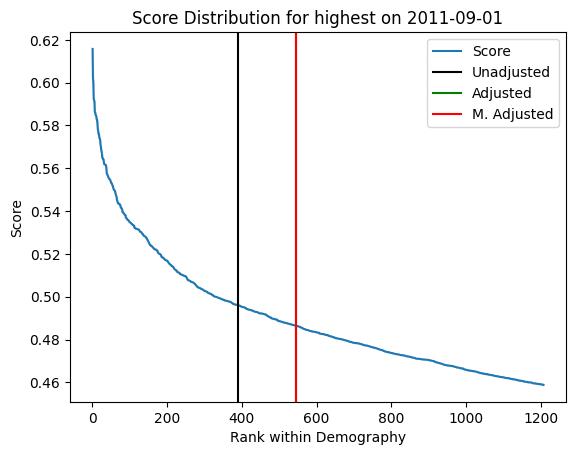

<Figure size 640x480 with 0 Axes>

In [18]:
plot_dist(include_timesteps=tsteps)

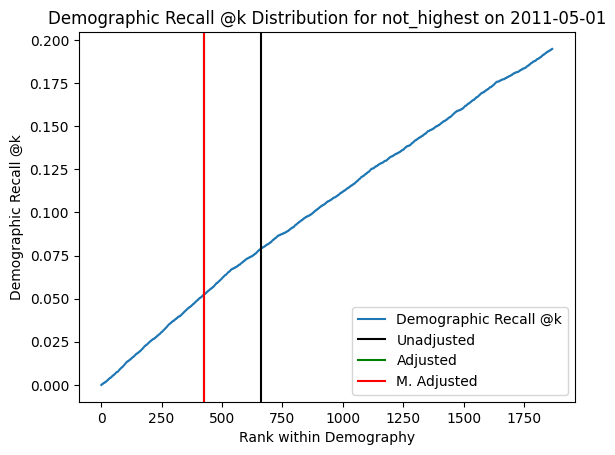

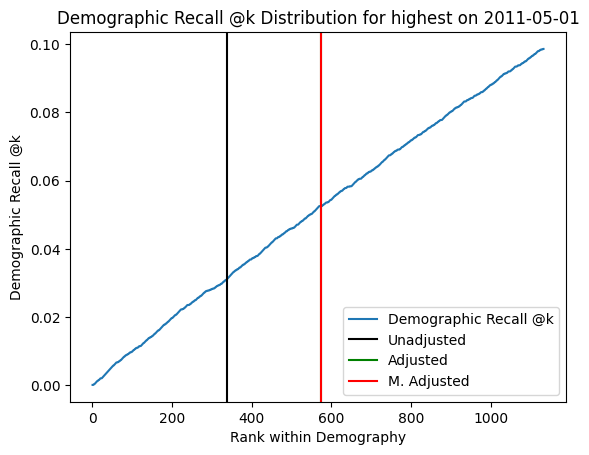

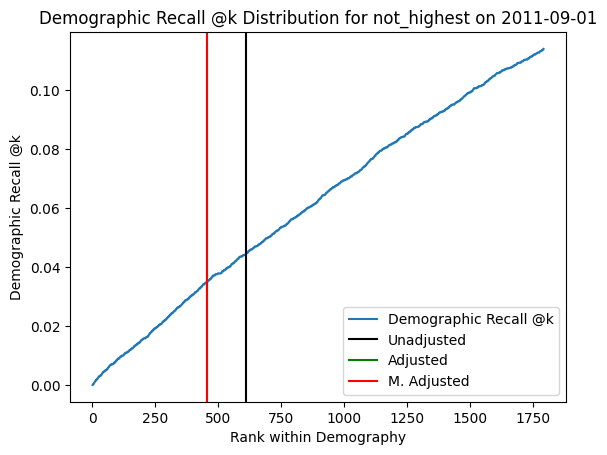

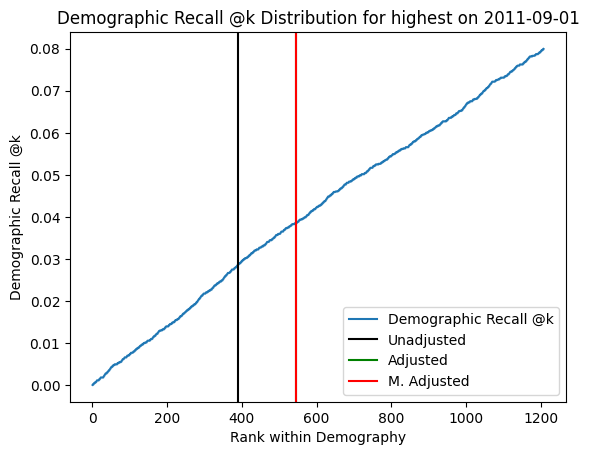

<Figure size 640x480 with 0 Axes>

In [19]:
plot_dist(metric="recall_demo_rolling", ylabel="Demographic Recall @k", include_timesteps=tsteps)

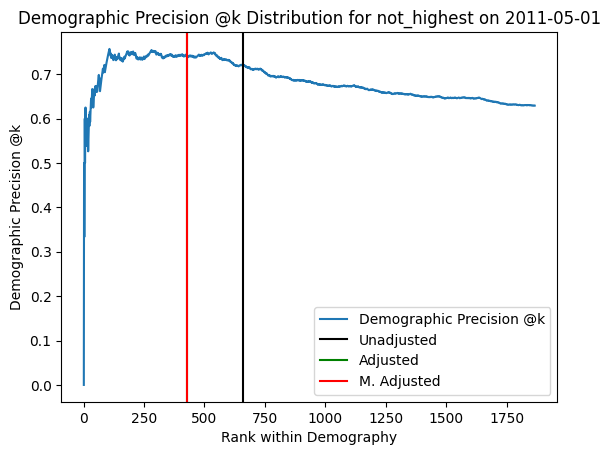

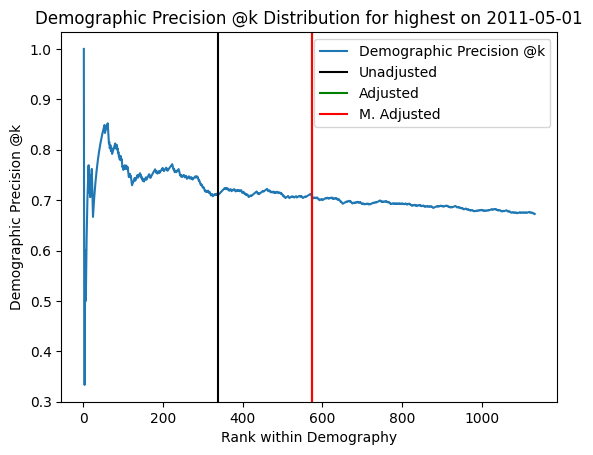

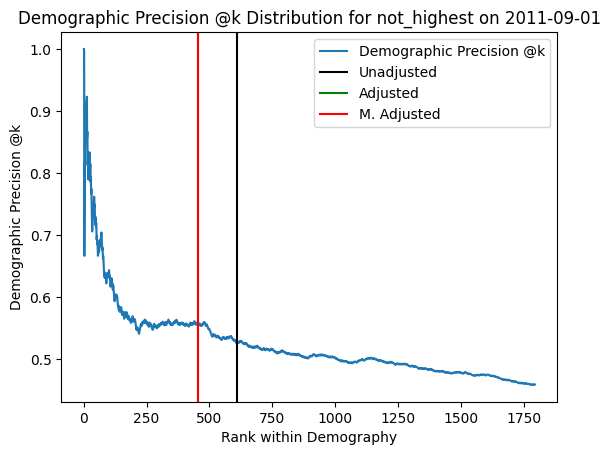

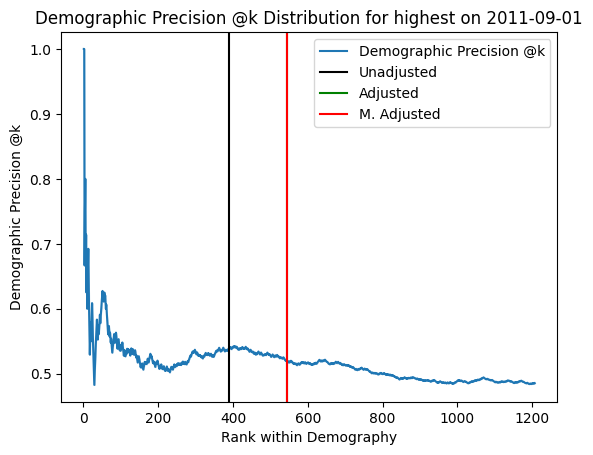

<Figure size 640x480 with 0 Axes>

In [20]:
plot_dist(metric="precision_demo_rolling", ylabel="Demographic Precision @k", include_timesteps=tsteps)

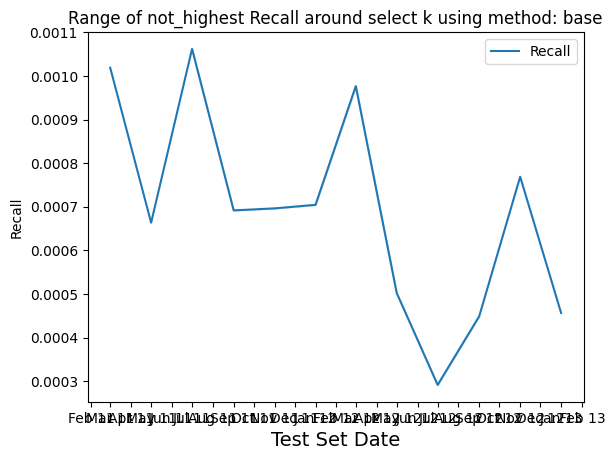

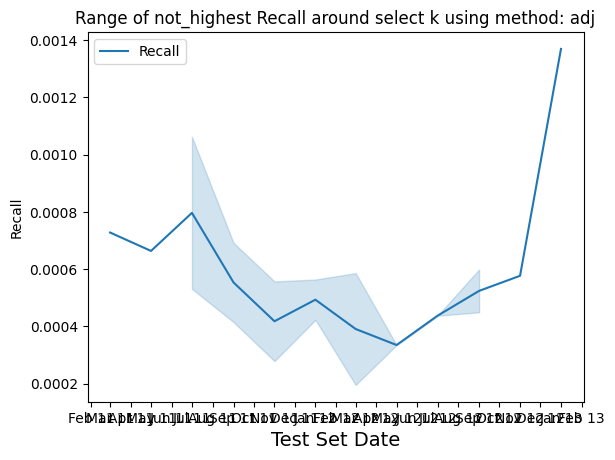

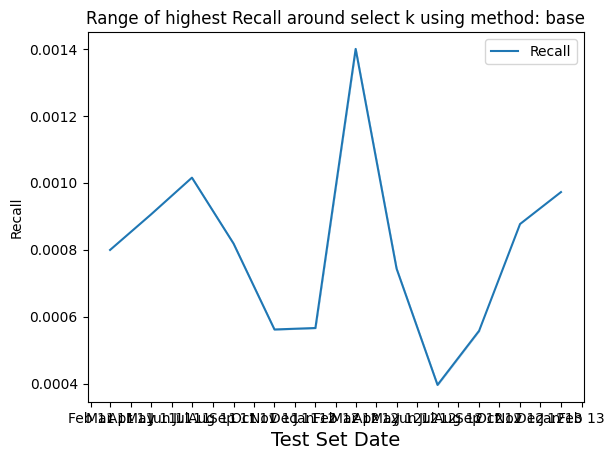

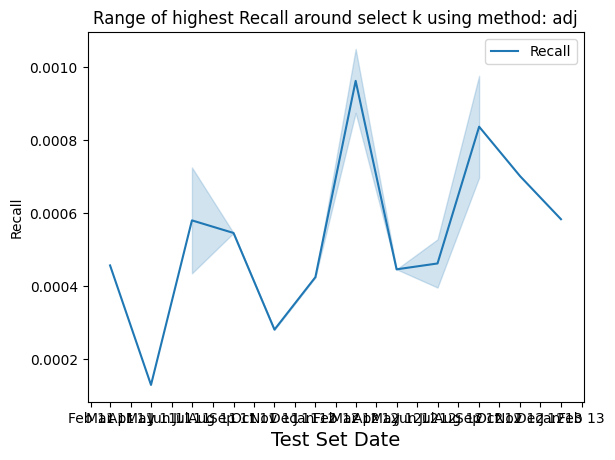

<Figure size 640x480 with 0 Axes>

In [21]:
plot_delta_dist(metric="recall_demo_rolling", ylabel="Recall")

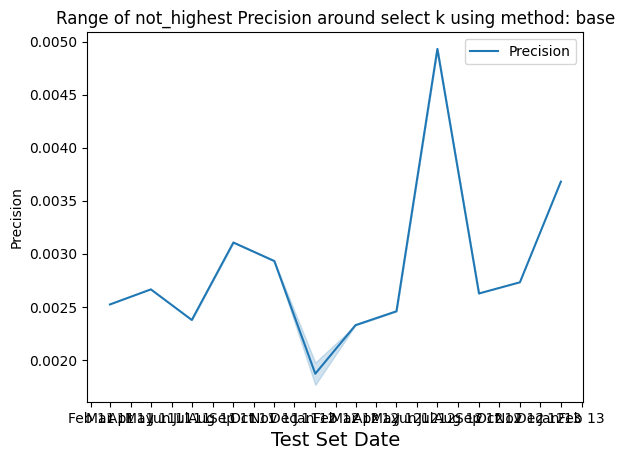

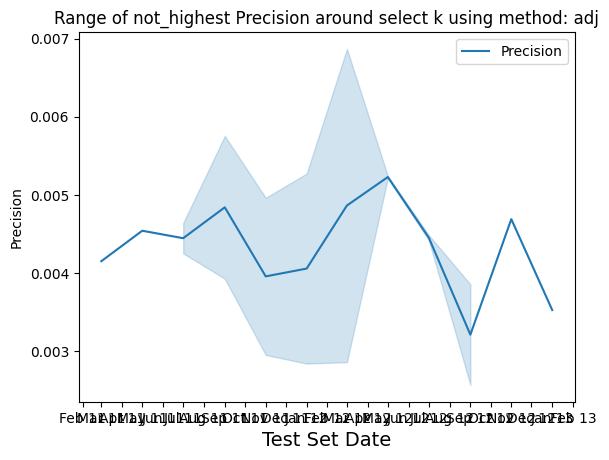

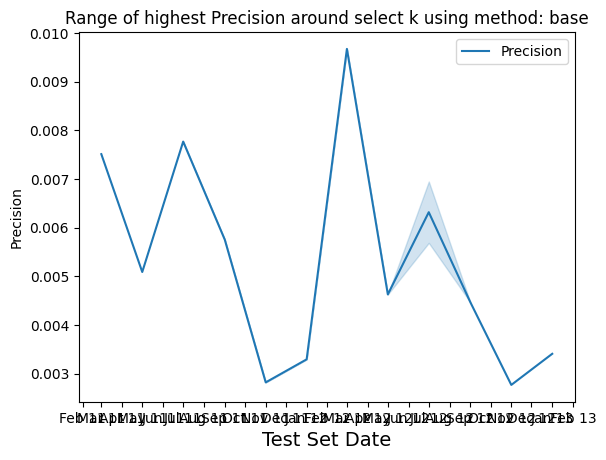

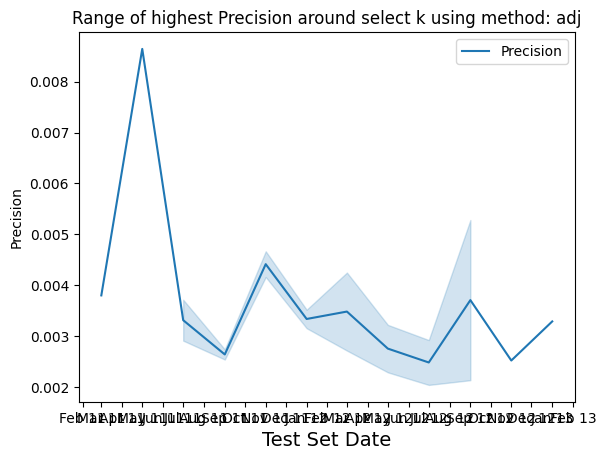

<Figure size 640x480 with 0 Axes>

In [22]:
plot_delta_dist(metric="precision_demo_rolling", ylabel="Precision")

# Performing Entity Analysis

Assumes that the model_adjustment_results_{demo_col} table is populated correctly for model selection

In [10]:
from DJRecallAdjuster import ra_procedure

In [11]:
ra_procedure(directory=database_directory, weights=[0.5, 0.5], pause_phases=False, entity_analysis=True)

[('2014-06-01', '2014-06-01'), ('2014-06-01', '2014-09-01')]
[('2014-09-01', '2014-09-01'), ('2014-09-01', '2014-12-01')]
[('2014-12-01', '2014-12-01'), ('2014-12-01', '2015-03-01')]
[('2015-03-01', '2015-03-01'), ('2015-03-01', '2015-06-01')]
[('2015-06-01', '2015-06-01'), ('2015-06-01', '2015-09-01')]
[('2015-09-01', '2015-09-01'), ('2015-09-01', '2015-12-01')]
[('2015-12-01', '2015-12-01'), ('2015-12-01', '2016-03-01')]
[('2016-03-01', '2016-03-01'), ('2016-03-01', '2016-04-01')]
